# Step 3 - Quanvolutional Neural Networks
- https://pennylane.ai/qml/demos/tutorial_quanvolution/

- This notebook uses quantum circuits to preprocess image data that are then fed into a custom keras model to be trained
  * load data
  * preprocess images
  * build model and train with quantum preprocessing images
  * build model and train with original images
  * compare results

In [1]:
#imports
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2024-08-08 06:29:05.006831: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 06:29:05.010385: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 06:29:05.021602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 06:29:05.039947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 06:29:05.045186: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-08 06:29:05.058265: I tensorflow/core/platform/cpu_feature_gu

In [2]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset -> take 50 images from train dataset
n_test = 30     # Size of the test dataset -> take 30 images from test dataset

SAVE_PATH = "./"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [3]:
# Load dataset
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

In [4]:
# what does our dataset look like?
print ("shape train images: ", train_images.shape)
print ("shape of train labels: ", train_labels.shape)

shape train images:  (60000, 28, 28)
shape of train labels:  (60000,)


In [5]:
# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1 -> needed for angle encoding
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [6]:
# Quantum and classical nodes
dev = qml.device("default.qubit", wires=4)

## Construct quanvolutional ansatz

In [7]:
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values -> AngleEncoding
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [8]:
# print one circuit 
print(qml.draw(circuit, expansion_strategy="device")([0.1,0.2,0.3,0.4]))

0: ──RY(0.31)──────────────────────────────────┤  <Z>
1: ──RY(0.63)──RY(3.72)─╭●─────────────────────┤  <Z>
2: ──RY(0.94)──RX(5.30)─│───RZ(5.39)──RX(5.32)─┤  <Z>
3: ──RY(1.26)───────────╰X─────────────────────┤  <Z>


In [9]:
# Define quanvolutional scheme
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

## Quantum Preprocessing of dataset

In [10]:
# now it's time to preprocess the images we got with our quantum circuit
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


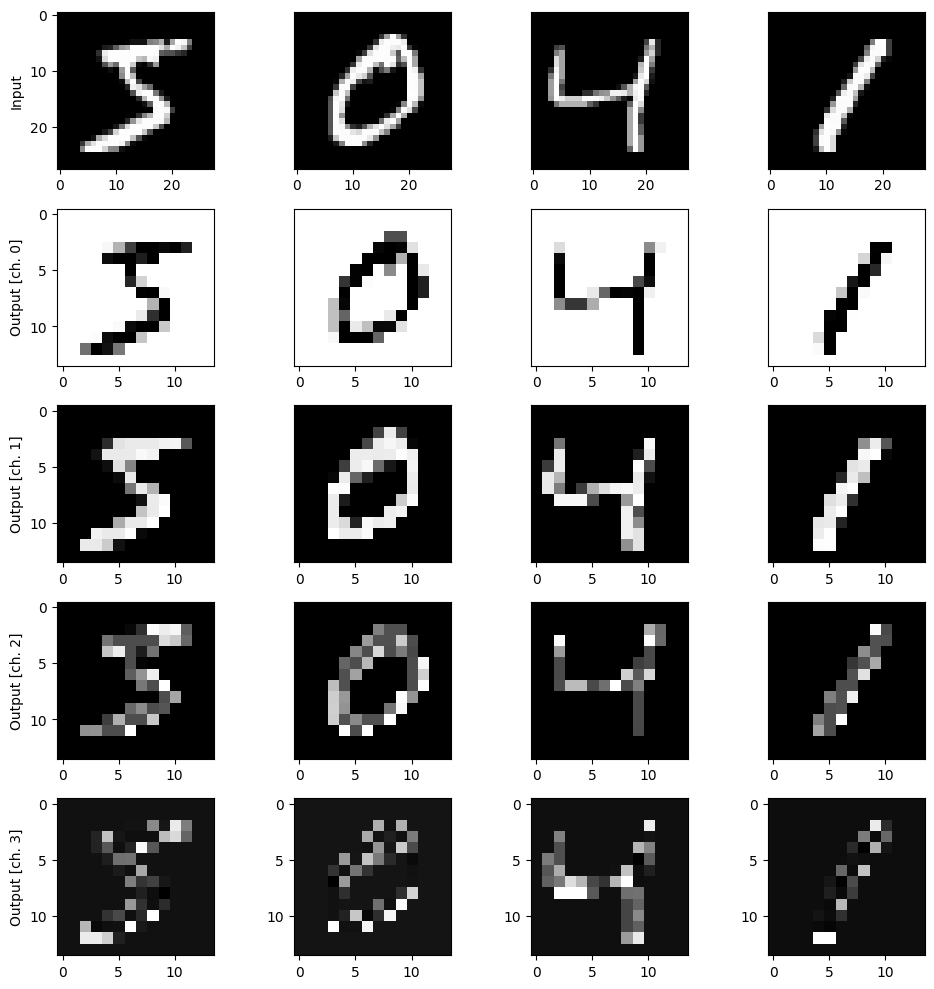

In [11]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

## Build Keras model: ADAM-optimizer and crossentropy

In [12]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Instantiate Optimizer and start training

In [13]:
# model with quantum test images
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 53ms/step - accuracy: 0.1600 - loss: 2.5183 - val_accuracy: 0.2000 - val_loss: 2.2841
Epoch 2/30
13/13 - 0s - 4ms/step - accuracy: 0.3800 - loss: 1.8667 - val_accuracy: 0.3000 - val_loss: 2.0579
Epoch 3/30
13/13 - 0s - 4ms/step - accuracy: 0.5600 - loss: 1.5564 - val_accuracy: 0.3667 - val_loss: 1.8933
Epoch 4/30
13/13 - 0s - 5ms/step - accuracy: 0.6600 - loss: 1.2681 - val_accuracy: 0.4333 - val_loss: 1.7688
Epoch 5/30
13/13 - 0s - 4ms/step - accuracy: 0.8200 - loss: 1.0596 - val_accuracy: 0.5000 - val_loss: 1.6604
Epoch 6/30
13/13 - 0s - 5ms/step - accuracy: 0.9200 - loss: 0.8851 - val_accuracy: 0.5667 - val_loss: 1.5775
Epoch 7/30
13/13 - 0s - 4ms/step - accuracy: 0.9200 - loss: 0.7489 - val_accuracy: 0.6333 - val_loss: 1.5091
Epoch 8/30
13/13 - 0s - 4ms/step - accuracy: 0.9400 - loss: 0.6389 - val_accuracy: 0.6333 - val_loss: 1.4507
Epoch 9/30
13/13 - 0s - 4ms/step - accuracy: 0.9600 - loss: 0.5489 - val_accuracy: 0.6333 - val_loss: 1.4026
Epoch 10/30
13/13 

In [14]:
# model with classic test images
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 45ms/step - accuracy: 0.1400 - loss: 2.2896 - val_accuracy: 0.2333 - val_loss: 2.1216
Epoch 2/30
13/13 - 0s - 4ms/step - accuracy: 0.4600 - loss: 1.8586 - val_accuracy: 0.3667 - val_loss: 1.9718
Epoch 3/30
13/13 - 0s - 4ms/step - accuracy: 0.7000 - loss: 1.5812 - val_accuracy: 0.5000 - val_loss: 1.8445
Epoch 4/30
13/13 - 0s - 4ms/step - accuracy: 0.8000 - loss: 1.3620 - val_accuracy: 0.5667 - val_loss: 1.7300
Epoch 5/30
13/13 - 0s - 5ms/step - accuracy: 0.9200 - loss: 1.1810 - val_accuracy: 0.6000 - val_loss: 1.6301
Epoch 6/30
13/13 - 0s - 5ms/step - accuracy: 0.9600 - loss: 1.0303 - val_accuracy: 0.6000 - val_loss: 1.5455
Epoch 7/30
13/13 - 0s - 4ms/step - accuracy: 0.9600 - loss: 0.9044 - val_accuracy: 0.6000 - val_loss: 1.4744
Epoch 8/30
13/13 - 0s - 4ms/step - accuracy: 0.9600 - loss: 0.7988 - val_accuracy: 0.6000 - val_loss: 1.4145
Epoch 9/30
13/13 - 0s - 4ms/step - accuracy: 0.9600 - loss: 0.7096 - val_accuracy: 0.6000 - val_loss: 1.3633
Epoch 10/30
13/13 

## Evaluate results

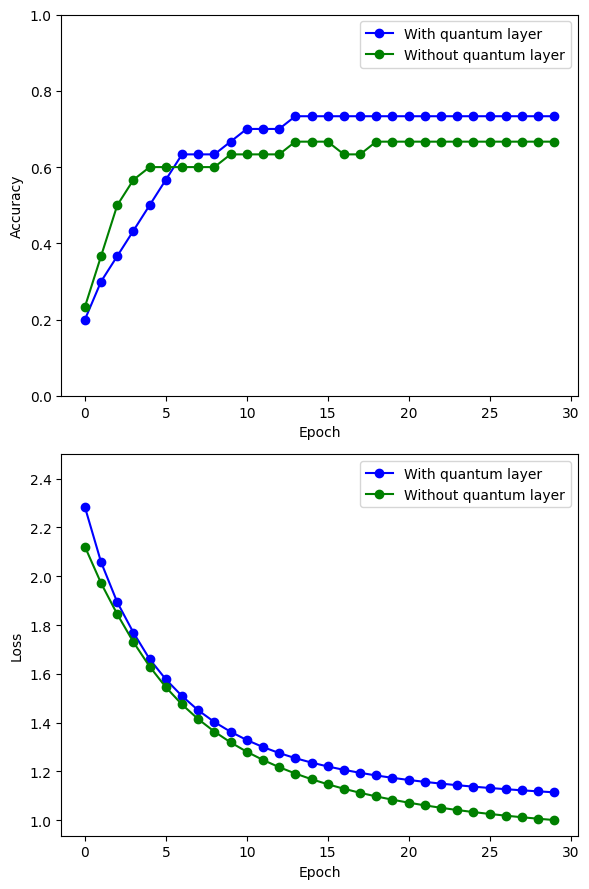

In [15]:
import matplotlib.pyplot as plt

#plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

We see that with our "quantum layer" (preprocessing of data) we achieve accuracy of 1.0 with 15 epochs instead of 20 with out preprocessing.
We also can see that loss function is steeper for the quantum case, but we can't beat the minimal loss achieved by classical model.